# 酶-靶标预测

这篇代码是预测酶与靶分子之间潜在相互作用的演示。这种方法利用了量子力学的原理，将优化问题表述为QUBO模型来解决它们。

数据集由 **MetXBioDB Metabolite Biotransformations** 提供

# **Importing Libraries**

In [39]:
import dimod
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler
import pandas as pd
from collections import defaultdict, Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem ,Descriptors, Draw
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import dynex

# **加载数据**

In [40]:
df = pd.read_csv('Transformations.csv', encoding='latin1', nrows=1000) 
df1 = pd.read_csv('substances.csv', encoding='latin1', nrows=1000) 
df2 = pd.read_csv('metabolicdb.csv', encoding='latin1', nrows=1000) 

### 检查数据类型

In [41]:
print("Data types in df:")
print(df[['Predecessor_CID', 'Successor_CID', 'Enzyme']].dtypes)
print("\nData types in df1:")
print(df1[['InChI', 'PubChem_CID', 'SMILES']].dtypes)
print("\nData types in df2:")
print(df2[['substrate_cid', 'prod_cid', 'enzyme']].dtypes)

Data types in df:
Predecessor_CID     int64
Successor_CID       int64
Enzyme             object
dtype: object

Data types in df1:
InChI          object
PubChem_CID     int64
SMILES         object
dtype: object

Data types in df2:
substrate_cid    float64
prod_cid          object
enzyme            object
dtype: object


### 合并数据集

In [42]:
df['Predecessor_Name'] = df['Predecessor_Name'].astype(str)
df['Successor_CID'] = df['Successor_CID'].astype(float)
df1['SubstanceName'] = df1['SubstanceName'].astype(str)
df1['PubChem_CID'] = df1['PubChem_CID'].astype(float)
df2['substrate_cid'] = df2['substrate_cid'].astype(str)
df2['prod_cid'] = df2['prod_cid'].astype(str)

# 第一次合并
mergedDf1 = pd.merge(df, df1, 
                      left_on=['Successor_CID'], 
                      right_on=['PubChem_CID'], 
                      how='inner')

# 第二次合并
mergedDf = pd.merge(mergedDf1, df2, 
                     left_on=['Enzyme'], 
                     right_on=['enzyme'], 
                     how='inner')

# 初始化

预处理数据集
计算酶频率
设置高频酶的阈值
按转化 [类型] 和酶进行分组，然后计算出现次数
过滤特定于单一酶的转化类型

In [43]:
%%time
enzymeCounter = Counter()
allPossiblePairs = set()
allPossibleEnzymes = set()
def updateSetsAndCounter(row):
    enzymes = row['Enzyme'].split('; ')
    enzymeCounter.update(enzymes)
    allPossiblePairs.add((row['Predecessor_CID'], row['Successor_CID']))
    allPossibleEnzymes.update(enzymes)
mergedDf.apply(updateSetsAndCounter, axis=1)
print("[INFO]: PHASE-1 DONE !")

enzymeFrequenciesDf = pd.DataFrame.from_dict(enzymeCounter, orient='index', columns=['Frequency']).reset_index()
enzymeFrequenciesDf.rename(columns={'index': 'Enzyme'}, inplace=True)
enzymeFrequenciesDf.sort_values(by='Frequency', ascending=False, inplace=True)
print("[INFO]: PHASE-2 DONE !")

highFrequencyEnzymes = set(enzymeFrequenciesDf[enzymeFrequenciesDf['Frequency'] >= 10]['Enzyme'])
print("[INFO]: PHASE-3 DONE !")

transformationEnzymeGroups = mergedDf.groupby(['Transformation', 'Enzyme']).size().reset_index(name='Counts')
enzymeSpecificTransformationsSet = set(
    transformationEnzymeGroups.groupby('Transformation')
    .filter(lambda x: len(x) == 1)['Transformation'])
print("[INFO]: PHASE-4 DONE !")

[INFO]: PHASE-1 DONE !
[INFO]: PHASE-2 DONE !
[INFO]: PHASE-3 DONE !
[INFO]: PHASE-4 DONE !
CPU times: total: 78.1 ms
Wall time: 91.1 ms


### 基于高频酶 / 转化 / **生物系统 [人类]**计算权重

In [44]:
%%time
def calculateWeights(row):
    rowBasedWeight = 10 * (row['Enzyme'] in highFrequencyEnzymes)
    rowBasedWeight += 5 * (row['Transformation'] in enzymeSpecificTransformationsSet)
    rowBasedWeight += 3 * (row['Biosystem'] == 'Human')
    return rowBasedWeight
mergedDf['Row_Based_Weight'] = mergedDf.apply(calculateWeights, axis=1)
print("[INFO]: PHASE-5 DONE !")

def calculateChemicalStructureWeight(inchi, smiles):
    weight = 0
    molInchi = Chem.MolFromInchi(inchi)
    molSmiles = Chem.MolFromSmiles(smiles)
    if molInchi and molSmiles:
        mwInchi = Descriptors.MolWt(molInchi)
        mwSmiles = Descriptors.MolWt(molSmiles)
        fpInchi = Chem.RDKFingerprint(molInchi)
        fpSmiles = Chem.RDKFingerprint(molSmiles)
        tanimotoSimilarity = DataStructs.FingerprintSimilarity(fpInchi, fpSmiles)
        weight = mwInchi * tanimotoSimilarity + mwSmiles
    return weight
print("[INFO]: PHASE-6 DONE !")


Q = defaultdict(int)
N = 5 # 至少有5对与X酶催化的情况。

# 更新 Q Model (Dictionary) [Q: QUBO Model]
def updateQ(row):
    try:
        enzymes = row['Enzyme'].split('; ')
        target = row['Successor_CID']
        predecessor = row['Predecessor_CID']
        weight1 = row['Row_Based_Weight']
        weight2 = calculateChemicalStructureWeight(row['InChI'], row['SMILES'])
        totalWeight = weight1 + weight2
        for enzyme in enzymes:
            enzyme = enzyme.strip()
            pair = f"{enzyme}_{predecessor}_{target}"
            Q[(pair, pair)] += -totalWeight
            for otherPredecessor, otherTarget in allPossiblePairs:
                otherPair = f"{enzyme}_{otherPredecessor}_{otherTarget}"
                Q[(pair, otherPair)] += 2 * N
    except Exception as e:
        print(f"An error occurred finding in chemical informatics: {e}")
        print(f"Skipping row: {row}")
mergedDf.apply(updateQ, axis=1)
print("[INFO]: PHASE-7 DONE !")

[INFO]: PHASE-5 DONE !
[INFO]: PHASE-6 DONE !
[INFO]: PHASE-7 DONE !
CPU times: total: 36.1 s
Wall time: 36.7 s


## 初始化Q-model的约束和相邻关系

In [45]:
def updatePairConstraint(predecessor, target):
    pairsForThisReaction = [
        f"{enzyme.strip()}_{predecessor}_{target}"
        for enzyme in allPossibleEnzymes
    ]
    for i, pair1 in enumerate(pairsForThisReaction):
        for j, pair2 in enumerate(pairsForThisReaction):
            if i != j:
                Q[(pair1, pair2)] -= 2  # 实验：至少有一个酶催化目标的情况。
print("[INFO]: PHASE-8 DONE !")

for predecessor, target in allPossiblePairs:
    updatePairConstraint(predecessor, target)
pairToIndex = {pair: i for i, pair in enumerate(allPossiblePairs)}
enzymeToIndex = {enzyme: j for j, enzyme in enumerate(allPossibleEnzymes)}
adjacencyMatrix = np.zeros((len(allPossiblePairs), len(allPossibleEnzymes)))
def updateAdjacencyMatrix(pair, i):
    for enzyme, j in enzymeToIndex.items():
        pairStr = f"{enzyme.strip()}_{pair[0]}_{pair[1]}"
        if (pairStr, pairStr) in Q:
            adjacencyMatrix[i, j] = 1            
print("[INFO]: PHASE-9 DONE !")

for pair, i in pairToIndex.items():
    updateAdjacencyMatrix(pair, i)
def refineConstraints(adjacencyMatrix):
    stronglyConnectedEnzymes = np.sum(adjacencyMatrix, axis=0) > 1
    stronglyConnectedPairs = np.sum(adjacencyMatrix, axis=1) > 1    
    for pair, i in pairToIndex.items():
        for enzyme, j in enzymeToIndex.items():
            pairStr = f"{enzyme.strip()}_{pair[0]}_{pair[1]}"
            qVal = Q.get((pairStr, pairStr), 0)
            if qVal:
                if stronglyConnectedEnzymes[j]:
                    Q[(pairStr, pairStr)] = qVal * 1.5  # Increase by 50%
                if stronglyConnectedPairs[i]:
                    Q[(pairStr, pairStr)] = qVal * 1.5  # Increase by 50%

refineConstraints(adjacencyMatrix)
print("[INFO]: PHASE-10 DONE !")

[INFO]: PHASE-8 DONE !
[INFO]: PHASE-9 DONE !
[INFO]: PHASE-10 DONE !


# 使用Dimod初始化QUBO [BQM]。

In [46]:
%%time
bqm = BinaryQuadraticModel.from_qubo(Q)

CPU times: total: 1.61 s
Wall time: 1.66 s


## 将约束和相邻关系应用于BQM。

In [47]:
for i, (predecessor, target) in enumerate(allPossiblePairs):
    for j, enzyme in enumerate(allPossibleEnzymes):
        pairStr = f"{enzyme.strip()}_{predecessor}_{target}"
        if adjacencyMatrix[i, j] == 1:
            if (pairStr, pairStr) in Q:
                bqm.set_linear(pairStr, Q[(pairStr, pairStr)])

## 在Dynex上进行计算

In [48]:
%%time
model = dynex.BQM(bqm);
sampler = dynex.DynexSampler(model,  mainnet=True, description='TargetPrediction_By_Rumony')
sampleset = sampler.sample(num_reads=10000, annealing_time = 1000, debugging=True);
bestSol = sampleset.first.sample

[DYNEX] SAMPLER INITIALISED
[DYNEX] MALLOB: JOB CREATED:  14210
[ÐYNEX] SUBMITTING JOB - UPLOADING JOB FILE...


file upload progress:   0%|          | 0.00/46.9M [00:00<?, ?B/s]

[DYNEX] File 'tmp/3f20513f337c452ca1774fd6e315390b.bin' sent successfully to 'ftp2.dynexcoin.org/'
[ÐYNEX] SUBMITTING START COMMAND...
[DYNEX] MALLOB: JOB UPDATED: 14210 STATUS: 0
[ÐYNEX] STARTING JOB...
╭────────────┬───────────┬───────────────────────────┬─────────┬─────────┬────────────────╮
│ DYNEXJOB   │ ELAPSED   │ WORKERS READ              │ CHIPS   │ STEPS   │ GROUND STATE   │
├────────────┼───────────┼───────────────────────────┼─────────┼─────────┼────────────────┤
│            │           │ *** WAITING FOR READS *** │         │         │                │
╰────────────┴───────────┴───────────────────────────┴─────────┴─────────┴────────────────╯
╭───────────────────────────────────┬───────────┬─────────┬───────┬──────────┬───────────┬───────────────┬──────────╮
│                            WORKER │   VERSION │   CHIPS │   LOC │   ENERGY │   RUNTIME │   LAST UPDATE │   STATUS │
├───────────────────────────────────┼───────────┼─────────┼───────┼──────────┼───────────┼──────────

In [49]:
#print('DYNEX 结果:',bestSol)

# 加载最好的解决结果

In [50]:
optimalPairs = [pair for pair, value in bestSol.items() if value == 1]
optimalTransformations = {}

for pair in optimalPairs:
    _, predecessor, target = pair.split('_')
    predQuery = df1.loc[df1['PubChem_CID'] == int(predecessor), 'SMILES']
    targetQuery = df1.loc[df1['PubChem_CID'] == float(target), 'SMILES']
    predecessorSmiles = predQuery.iloc[0] if not predQuery.empty else 'Not Found'
    targetSmiles = targetQuery.iloc[0] if not targetQuery.empty else 'Not Found'
    optimalTransformations[predecessorSmiles] = targetSmiles

    #print(f"Optimal transformation: {predecessorSmiles} -> {targetSmiles}")

## - 可视化

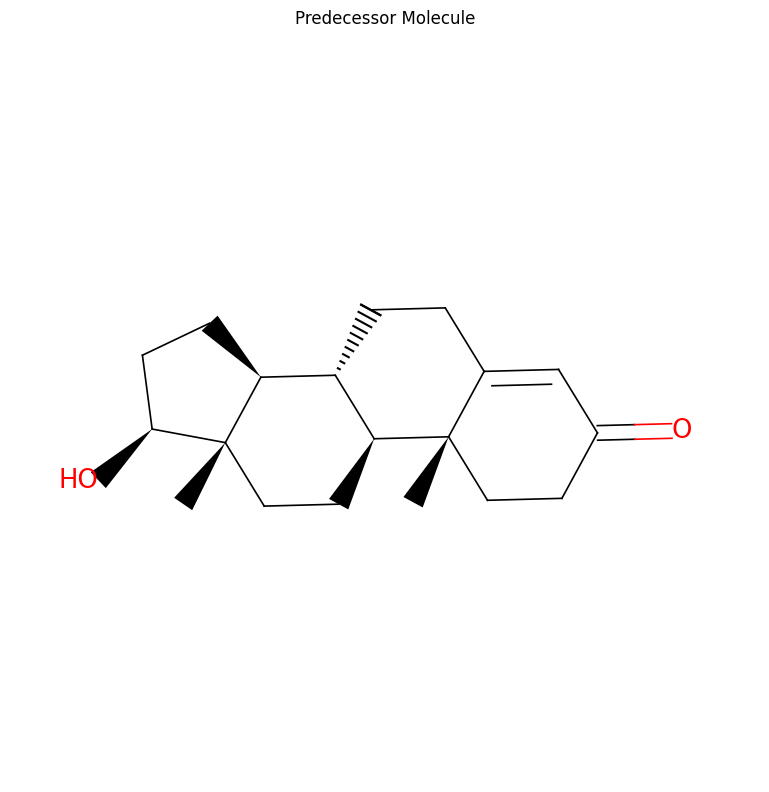

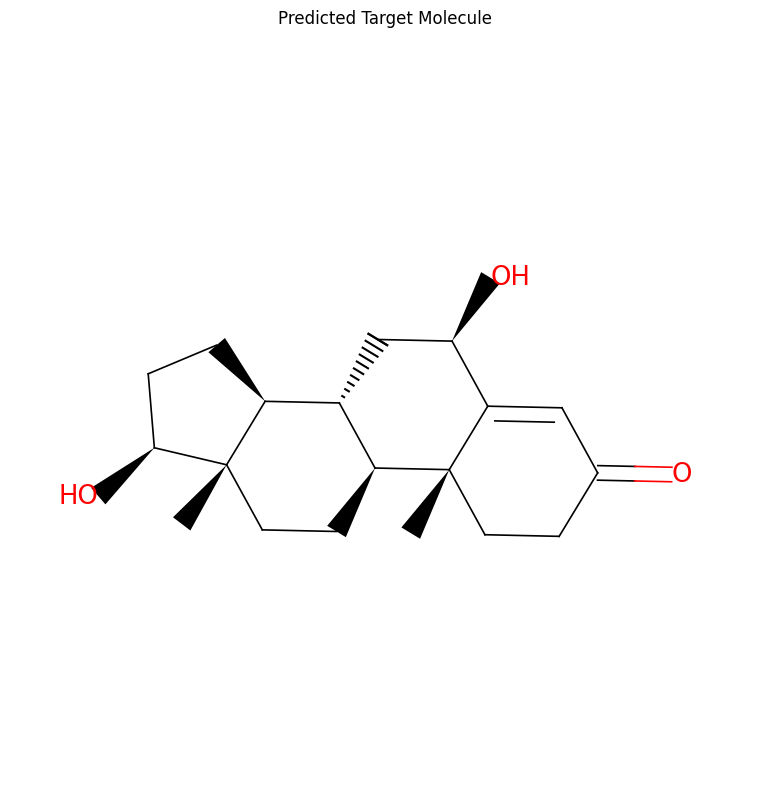

In [51]:
def Visualize(predecessorSmiles):
    targetSmiles = optimalTransformations.get(predecessorSmiles, "Not found")
    if targetSmiles == "Not found":
        print("Predecessor SMILES not found in the optimal transformations.")
        return
    # Drawing predecessor molecule
    predMol = Chem.MolFromSmiles(predecessorSmiles)
    predImg = Draw.MolToMPL(predMol, size=(300, 300), kekulize=True)
    plt.title("Predecessor Molecule")
    plt.axis("off")
    plt.show()
    
    # Drawing target molecule
    targetMol = Chem.MolFromSmiles(targetSmiles)
    targetImg = Draw.MolToMPL(targetMol, size=(300, 300), kekulize=True)
    plt.title("Predicted Target Molecule")
    plt.axis("off")
    plt.show()

predecessorSmiles = "C[C@]12CCC(=O)C=C1CC[C@H]1[C@@H]3CC[C@@H]([C@@]3(C)CC[C@H]21)O" # EXAMPLE 
Visualize(predecessorSmiles)